In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import circmean
import fly_analysis as fa
from tqdm import tqdm
import pickle
from datetime import datetime
import os

date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
print(date_time)

20241030_232611


# Analysis functions

In [19]:
def sg_smooth(df):
    """
    Applies Savitzky-Golay filter to smooth specified columns in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the columns to be smoothed.

    Returns:
    pandas.DataFrame: The DataFrame with smoothed columns.

    The function applies the Savitzky-Golay filter with a window length of 21 and a polynomial order of 3
    to the columns 'x', 'y', 'z', 'xvel', 'yvel', and 'zvel' in the input DataFrame.
    """
    columns = ["x", "y", "z", "xvel", "yvel", "zvel"]
    df[columns] = df[columns].apply(lambda x: savgol_filter(x, 21, 3))
    return df

def get_angular_velocity(xvel, yvel, dt=0.01):
    """
    Calculate the angular velocity from x and y velocity components.

    Parameters:
    xvel (array-like): The x-component of the velocity.
    yvel (array-like): The y-component of the velocity.
    dt (float, optional): The time step between velocity measurements. Default is 0.01.

    Returns:
    numpy.ndarray: The angular velocity calculated from the input velocities.
    """
    theta = np.arctan2(yvel, xvel)
    theta_unwrap = np.unwrap(theta)
    return np.gradient(theta_unwrap, dt)


def get_linear_velocity(xvel, yvel):
    """
    Calculate the linear velocity given the x and y components of velocity.

    Parameters:
    xvel (float): The velocity component in the x direction.
    yvel (float): The velocity component in the y direction.

    Returns:
    float: The linear velocity calculated using the Pythagorean theorem.
    """
    return np.sqrt(xvel**2 + yvel**2)


def get_saccades(angular_velocity, linear_velocity, **kwargs):
    """
    Detects saccades in the given angular velocity data.

    Parameters:
    angular_velocity (array-like): The angular velocity data to analyze.
    **kwargs: Additional keyword arguments for peak detection.
        - height (float, optional): Minimum height of peaks. Default is np.deg2rad(300).
        - distance (int, optional): Minimum distance between peaks. Default is 20.

    Returns:
    array: Indices of the detected saccades.
    """
    saccades = find_peaks(
        np.abs(angular_velocity),
        height=kwargs.get("height", np.deg2rad(300)),
        distance=kwargs.get("distance", 20),
    )[0]

    saccades = saccades[linear_velocity[saccades] > kwargs.get("min_speed", 0.1)]
    return saccades


def plot_mean_and_std(
    arr,
    ax=None,
    take_abs=True,
    units="frames",
    convert_to_degrees=False,
    peak_align=False,
    label=None,
):
    """
    Plots the mean and standard deviation of the given array.

    Parameters:
    arr (numpy.ndarray): The input array to compute mean and standard deviation.
    ax (matplotlib.axes.Axes, optional): The axes on which to plot. If None, a new figure and axes are created.
    take_abs (bool, optional): If True, takes the absolute value of the array before computing mean and std. Default is True.
    label (str, optional): The label for the plot. Default is None.

    Returns:
    matplotlib.axes.Axes: The axes with the plot.
    """
    if ax is None:
        _, ax = plt.subplots()

    data = arr.copy()

    if peak_align:
        take_abs = False
        # Find peaks only within specified window
        start_idx, end_idx = 50, 80
        peak_indices = start_idx + np.argmax(np.abs(data[:, start_idx:end_idx]), axis=1)

        # Flip based on peak sign
        for i, peak_idx in enumerate(peak_indices):
            if data[i, peak_idx] < 0:
                data[i] = -data[i]

    if take_abs:
        data = np.abs(data)

    mean = np.nanmean(data, axis=0)
    std = np.nanstd(data, axis=0)

    if convert_to_degrees:
        mean = np.rad2deg(mean)
        std = np.rad2deg(std)

    x = np.arange(len(mean))

    ax.plot(x, mean, label=label)
    ax.fill_between(x, mean - std, mean + std, alpha=0.2)

    if convert_to_degrees:
        ax.set_ylabel("Angular Velocity (deg/s)")
    else:
        ax.set_ylabel("Angular Velocity (rad/s)")

    return ax


def plot_histogram(arr, ax=None, label=None):
    """
    Plots a histogram of the given array with a density estimate.

    Parameters:
    arr (array-like): The input data array to plot.
    ax (matplotlib.axes.Axes, optional): The axes on which to plot the histogram.
                                         If None, a new figure and axes are created.
    label (str, optional): The label for the histogram.

    Returns:
    matplotlib.axes.Axes: The axes with the plotted histogram.
    """
    if ax is None:
        _, ax = plt.subplots()

    sns.histplot(
        arr,
        ax=ax,
        bins=36,
        binrange=(-np.pi, np.pi),
        stat="density",
        kde=True,
    )
    return ax


def calculate_inverted_signed_angle(v1, v2):
    # Calculate the signed angle between two vectors
    angle = np.arctan2(np.cross(v1, v2), np.dot(v1, v2))

    # Invert the angle
    if angle >= 0:
        inverted_angle = np.pi - angle
    else:
        inverted_angle = -np.pi - angle

    return inverted_angle  # This will be in radians, in the range [-π, π]


def get_heading_difference_for_trajectory(xyz, midpoint=65, n_around=10):
    if np.shape(xyz)[1] == 3:
        xyz = xyz[:, :2]

    vector_before = xyz[midpoint - n_around] - xyz[midpoint]
    vector_after = xyz[midpoint + n_around] - xyz[midpoint]

    return calculate_inverted_signed_angle(vector_before, vector_after)


def extract_saccade_angvel(angular_velocity, idx, n_before, n_after):
    return angular_velocity[idx - n_before : idx + n_after]


def extract_saccade_linvel(linear_velocity, idx, n_before, n_after):
    return linear_velocity[idx - n_before : idx + n_after]


def flatten_nested(lst):
    result = []
    for item in lst:
        if isinstance(item, list):
            result.extend(flatten_nested(item))
        else:
            result.append(item)
    return result



## Main saccade analysis

In [1]:
import numpy as np
from tqdm import tqdm
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any, Optional

@dataclass
class SaccadeConfig:
    """Configuration parameters for saccade detection and analysis"""
    n_before: int = 100  # frames before saccade
    n_after: int = 100   # frames after saccade
    stim_window: int = 50  # window to look for stimulus-elicited saccades
    min_group_length: int = 200
    delay: int = 15  # delay for no-saccade cases
    ang_vel_threshold: float = np.deg2rad(300)  # minimum angular velocity for saccade
    lin_vel_threshold: float = 0.01  # minimum linear velocity for saccade
    peak_distance: int = 40  # minimum distance between peaks

def detect_saccades(
    angular_velocity: np.ndarray,
    linear_velocity: np.ndarray,
    config: SaccadeConfig
) -> np.ndarray:
    """
    Detect saccades based on angular and linear velocity thresholds.
    
    Args:
        angular_velocity: Array of angular velocities
        linear_velocity: Array of linear velocities
        config: Configuration parameters
        
    Returns:
        Array of indices where saccades were detected
    """
    # Find peaks in angular velocity that exceed threshold
    peaks = find_peaks(
        np.abs(angular_velocity), 
        height=config.ang_vel_threshold,
        distance=config.peak_distance
    )[0]
    
    # Filter peaks by linear velocity threshold

    valid_peaks = peaks[linear_velocity[peaks] > config.lin_vel_threshold]
    
    return valid_peaks

def extract_saccade_window(
    data: np.ndarray,
    idx: int,
    config: SaccadeConfig
) -> Optional[np.ndarray]:
    """
    Extract window of data around a saccade index.
    
    Args:
        data: Array of data to extract from
        idx: Center index for extraction
        config: Configuration parameters
        
    Returns:
        Window of data or None if invalid indices
    """
    if idx - config.n_before < 0 or idx + config.n_after >= len(data):
        return None
    
    return data[idx - config.n_before:idx + config.n_after]

def get_peak_in_window(
    angular_velocity: np.ndarray,
    linear_velocity: np.ndarray,
    ang_vel_threshold: float,
    lin_vel_threshold: float
) -> Optional[int]:
    """Find index of highest angular velocity peak that meets both velocity thresholds."""
    # Find maximum absolute angular velocity
    abs_ang_vel = np.abs(angular_velocity)
    max_val = np.max(abs_ang_vel)
    
    if max_val > ang_vel_threshold:
        peak_idx = np.argmax(abs_ang_vel)
        # Check if linear velocity at peak meets threshold
        if linear_velocity[peak_idx] > lin_vel_threshold:
            return peak_idx
    return None

def get_continuous_segments(frames):
    """Return indices where continuous frame segments start/end."""
    breaks = np.where(np.diff(frames) > 1)[0] + 1
    starts = np.concatenate(([0], breaks))
    ends = np.concatenate((breaks, [len(frames)]))
    return list(zip(starts, ends))

def is_in_center(x, y, z, x_lim=0.2, y_lim=0.2, z_min=0.05, z_max=0.3):
    """Check if position is in central arena region."""
    return (abs(x) < x_lim and 
            abs(y) < y_lim and 
            z_min < z < z_max)

def save_trajectory_plots(data: dict, save_dir: str):
    """Save angular and linear velocity plots for each trajectory."""
    import matplotlib.pyplot as plt
    import os
    
    for group in set(data['group']):
        # Create group directory
        group_dir = os.path.join(save_dir, group)
        os.makedirs(group_dir, exist_ok=True)
        
        # Get indices for this group
        group_indices = [i for i, g in enumerate(data['group']) if g == group]
        
        for idx in group_indices:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
            
            # Plot angular velocity
            ax1.plot(data['angular_velocity'][idx])
            ax1.set_title(f'{group} - Angular Velocity')
            ax1.set_ylabel('rad/s')
            
            # Plot linear velocity
            ax2.plot(data['linear_velocity'][idx])
            ax2.set_title('Linear Velocity')
            ax2.set_ylabel('m/s')
            ax2.set_xlabel('Frame')
            
            plt.tight_layout()
            plt.savefig(os.path.join(group_dir, f'trajectory_{idx}.png'))
            plt.close()

def get_all_saccade_data(df, stim, save_plots=False, plot_dir=None, **kwargs):
    config = SaccadeConfig(**kwargs)
    
    # initialize results dictionary
    results = {
        'angular_velocity': [],
        'linear_velocity': [],
        'heading_diff': [],
        'group': [],
    }
    
    # iterate over each stimulus
    for _, row in tqdm(stim.iterrows(), total=len(stim)):

        # get group data
        group_mask = (df['obj_id'] == row['obj_id']) & (df['exp_num'] == row['exp_num'])
        grp = df[group_mask].copy()
        
        # skip groups with insufficient data
        if len(grp) < config.min_group_length:
            continue
        
        # get stimulus index
        stim_idx = np.where(grp["frame"] == row["frame"])[0]
        if len(stim_idx) == 0:  # skip if stimulus not found
            stim_idx = None
        else: # take first index if multiple found
            stim_idx = stim_idx[0]

        # Smooth data
        grp = sg_smooth(grp)

        # Calculate angular and linear velocity
        xvel, yvel = grp['xvel'].to_numpy(), grp['yvel'].to_numpy()
        x, y ,z = grp['x'].to_numpy(), grp['y'].to_numpy(), grp['z'].to_numpy()
        angular_velocity = get_angular_velocity(xvel, yvel)
        linear_velocity = get_linear_velocity(xvel, yvel)

        # Detect saccades
        saccade_indices = find_peaks(np.abs(angular_velocity), height=config.ang_vel_threshold, distance=config.peak_distance)[0]

        # Extract saccade data
        for sac_idx in saccade_indices:
            
            # skip values out of bounds
            if sac_idx < config.n_before or sac_idx + config.n_after >= len(angular_velocity):
                continue
            
            # skip saccades around stimulus
            if stim_idx-config.n_before < sac_idx < stim_idx+config.n_after:
                continue
            
            # only process saccades occuring in the central region
            if (0.05 <= z[sac_idx] <= 0.3) and (-0.2 <= x[sac_idx] <= 0.2) and (-0.2 <= y[sac_idx] <= 0.2):
                results["angular_velocity"].append(angular_velocity[sac_idx - config.n_before:sac_idx + config.n_after])
                results["linear_velocity"].append(linear_velocity[sac_idx - config.n_before:sac_idx + config.n_after])
                results["heading_diff"].append(get_heading_difference_for_trajectory(grp[['x', 'y', 'z']].to_numpy(), sac_idx))
                results["group"].append("spontaneous")

        # detect stimulus-elicited saccades
        angular_velocity_stim_window = angular_velocity[stim_idx:stim_idx+config.stim_window]

        # Find peak in stimulus window
        peaks = find_peaks(np.abs(angular_velocity_stim_window), height=config.ang_vel_threshold, distance=config.peak_distance)[0]

        if len(peaks) == 0: # no saccade detected
            stim_idx += 15 # add delay
            stim_group = "stim_no_saccade" # no saccade group
        else: # saccade detected
            stim_idx += peaks[0] # adjust index to peak
            stim_group = "stim_saccade" # saccade group

        # Extract saccade data
        if stim_idx < config.n_before or stim_idx + config.n_after >= len(angular_velocity):
            continue
        
        results["angular_velocity"].append(angular_velocity[stim_idx - config.n_before:stim_idx + config.n_after])
        results["linear_velocity"].append(linear_velocity[stim_idx - config.n_before:stim_idx + config.n_after])
        results["heading_diff"].append(get_heading_difference_for_trajectory(grp[['x', 'y', 'z']].to_numpy(), stim_idx))
        results["group"].append(stim_group)
    
    # convert lists to numpy arrays
    for key in results:
        results[key] = np.array(results[key])
    
    return results

In [4]:
def group_index(results, group):
    return np.array([i for i, x in enumerate(results["group"]) if x == group]).astype(int)

In [5]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"
checkpoint_path = "/home/buchsbaum/src/fly_analysis/notebooks/checkpoints/"
data_path = "/home/buchsbaum/src/fly_analysis/notebooks/data/"

## Load Data

In [6]:
import os
import pandas as pd
from typing import List, Dict, Optional, Literal
from pathlib import Path
import h5py
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np

StorageFormat = Literal['parquet', 'hdf5', 'feather']

def process_braidz_files(
    files: List[str],
    root_folder: str,
    output_path: str,
    group_id: str,
    storage_format: StorageFormat = 'parquet',
    compression: Optional[str] = 'snappy'
) -> Dict[str, pd.DataFrame]:
    """
    Process braidz files and save results in efficient format for large datasets.
    
    Args:
        files: List of braidz filenames to process
        root_folder: Root directory containing the braidz files
        output_path: Directory where processed files should be saved
        group_id: Group identifier for organizing output files
        storage_format: Format to save data in ('parquet', 'hdf5', or 'feather')
        compression: Compression method (format-specific, default 'snappy' for parquet)
    
    Returns:
        Dictionary mapping keys to processed DataFrames
    
    Storage Format Details:
        - parquet: Best for column-oriented data, good compression, splittable
        - hdf5: Good for hierarchical data, fast random access
        - feather: Fastest read/write times, but larger file size
    """
    # Create output directory if it doesn't exist
    group_output_dir = Path(output_path) / group_id
    group_output_dir.mkdir(parents=True, exist_ok=True)
    
    def get_file_extension() -> str:
        return {
            'parquet': '.parquet',
            'hdf5': '.h5',
            'feather': '.feather'
        }[storage_format]
    
    def save_dataframe(df: pd.DataFrame, key: str, output_file: Path) -> None:
        if storage_format == 'parquet':
            # Parquet with snappy compression (good balance of speed/size)
            df.to_parquet(
                output_file,
                compression=compression,
                index=False,
                engine='pyarrow'
            )
        elif storage_format == 'hdf5':
            # HDF5 with table format for better performance with large datasets
            df.to_hdf(
                output_file,
                key=key,
                mode='a',
                format='table',
                complevel=5 if compression else 0,
                complib='blosc:lz4'
            )
        elif storage_format == 'feather':
            # Feather format with optional LZ4 compression
            df.to_feather(
                output_file,
                compression=compression
            )
    
    def read_dataframe(file_path: Path, key: str) -> pd.DataFrame:
        if storage_format == 'parquet':
            return pd.read_parquet(file_path)
        elif storage_format == 'hdf5':
            return pd.read_hdf(file_path, key=key)
        elif storage_format == 'feather':
            return pd.read_feather(file_path)
    
    # Check if all files already exist
    def get_existing_data() -> Optional[Dict[str, pd.DataFrame]]:
        try:
            extension = get_file_extension()
            existing_files = list(group_output_dir.glob(f"*{extension}"))
            
            if not existing_files:
                return None
            
            if storage_format == 'hdf5':
                # For HDF5, all data is in one file
                h5_file = group_output_dir / f"data{extension}"
                if not h5_file.exists():
                    return None
                with h5py.File(h5_file, 'r') as f:
                    return {
                        key: pd.read_hdf(h5_file, key=key)
                        for key in f.keys()
                    }
            else:
                # For parquet and feather, each DataFrame is in a separate file
                return {
                    file.stem: read_dataframe(file, file.stem)
                    for file in existing_files
                }
                
        except Exception as e:
            print(f"Error reading existing files: {e}")
            return None
    
    # Try to load existing data first
    existing_data = get_existing_data()
    if existing_data is not None:
        print(f"Loaded existing {storage_format} files for {group_id}")
        return existing_data
    
    # Process braidz files if data doesn't exist
    try:
        print(f"Processing {group_id} files: {', '.join(files)}")
        processed_data = fa.braidz.read_multiple_braidz(files, root_folder)
        
        # Save processed data
        if storage_format == 'hdf5':
            # Save all DataFrames to a single HDF5 file
            output_file = group_output_dir / f"data{get_file_extension()}"
            for key, df in processed_data.items():
                if not isinstance(df, pd.DataFrame):
                    continue
                save_dataframe(df, key, output_file)
                print(f"Saved {key} to {output_file}")
        else:
            # Save each DataFrame to a separate file
            for key, df in processed_data.items():
                if not isinstance(df, pd.DataFrame):
                    continue
                output_file = group_output_dir / f"{key}{get_file_extension()}"
                save_dataframe(df, key, output_file)
                print(f"Saved {key} to {output_file}")
            
        return processed_data
        
    except Exception as e:
        print(f"Error processing braidz files: {e}")
        raise

### DNp03

In [7]:
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data = process_braidz_files(j53xu68_files, root_folder, data_path, "dnp03", storage_format='parquet')

Loaded existing parquet files for dnp03


In [23]:
j53_results = get_all_saccade_data(j53_data["df"], j53_data["stim"])

Processing chunks:   0%|          | 0/107 [00:00<?, ?it/s]

: 

### AX-Split

In [40]:
# Process g29xu68 files
print("Processing g29xu68 files")
g29xu68_files = ["20230512_144203.braidz", "20230203_145747.braidz"]
g29_data = fa.braidz.read_multiple_braidz(g29xu68_files, root_folder)

Processing g29xu68 files
Reading /home/buchsbaum/mnt/md0/Experiments/20230512_144203.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230203_145747.braidz using pyarrow


In [140]:
g29_results = get_all_saccade_data(g29_data["df"], g29_data["stim"])

100%|██████████| 1574/1574 [02:55<00:00,  8.97it/s]


### Empty-Split

In [ ]:
# Process emptyxu68 files
print("Processing emptyxu68 files")
emptyxu68_files = [
    "20231020_150051.braidz",
    "20230530_115028.braidz",
]
empty_data = fa.braidz.read_multiple_braidz(emptyxu68_files, root_folder)

In [ ]:
empty_split_results = get_all_saccade_data(empty_data["df"], empty_data["stim"])

# Plots

## Optogenetics

In [138]:
def opto_summary_plot(data: dict, group: str):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

    stim_w_saccade_indices = group_index(data, "stim_saccade")
    spont_saccade_indices = group_index(data, "spontaneous")
    stim_no_saccade_indices = group_index(data, "stim_no_saccade")

    angular_velocities =np.rad2deg(np.array(data["angular_velocity"]))
    linear_velocities = np.array(data["linear_velocity"])
    heading_diffs = np.array(data["heading_diff"])

    def plot_mean_and_std(data, ax, label=None):
        data = np.abs(data)
        mean = np.mean(data, axis=0)
        std = np.std(data, axis=0)

        ax.plot(mean, label=label)
        ax.fill_between(np.arange(len(mean)), mean - std, mean + std, alpha=0.2)
        return ax
    
    # angvel
    plot_mean_and_std(
        angular_velocities[spont_saccade_indices],
        label="Spont",
        ax=axs[0],
    )
    plot_mean_and_std(
        angular_velocities[stim_w_saccade_indices],
        label="Stim",
        ax=axs[0],
    )
    plot_mean_and_std(
        angular_velocities[stim_no_saccade_indices],
        label="Stim no saccade",
        ax=axs[0],
    )

    # linvel
    plot_mean_and_std(linear_velocities[spont_saccade_indices], ax=axs[1])
    plot_mean_and_std(linear_velocities[stim_w_saccade_indices],  ax=axs[1])
    plot_mean_and_std(linear_velocities[stim_no_saccade_indices],  ax=axs[1])

    # heading_difference
    plot_histogram(heading_diffs[spont_saccade_indices], ax=axs[2])
    plot_histogram(heading_diffs[stim_w_saccade_indices], ax=axs[2])
    plot_histogram(heading_diffs[stim_no_saccade_indices], ax=axs[2])

    axs[0].set_xlabel("Frames")
    axs[0].set_ylabel("Angular Velocity (deg/s)")
    
    axs[1].set_xlabel("Frames")
    axs[1].set_ylabel("Linear Velocity (m/s)")

    axs[2].set_xlabel("Direction change (degrees)")
    axs[2].set_ylabel("Probability Density")

    plt.suptitle(f"{group}")
    plt.tight_layout()

    folder = os.path.join("/home/buchsbaum/src/fly_analysis/notebooks/Figures/dnp03_paper/", date_time)
    os.makedirs(folder, exist_ok=True)

    plt.savefig(os.path.join(folder, f"{group}.png"), dpi=300)
    plt.show()
    # close
    plt.close()

#### DNp03

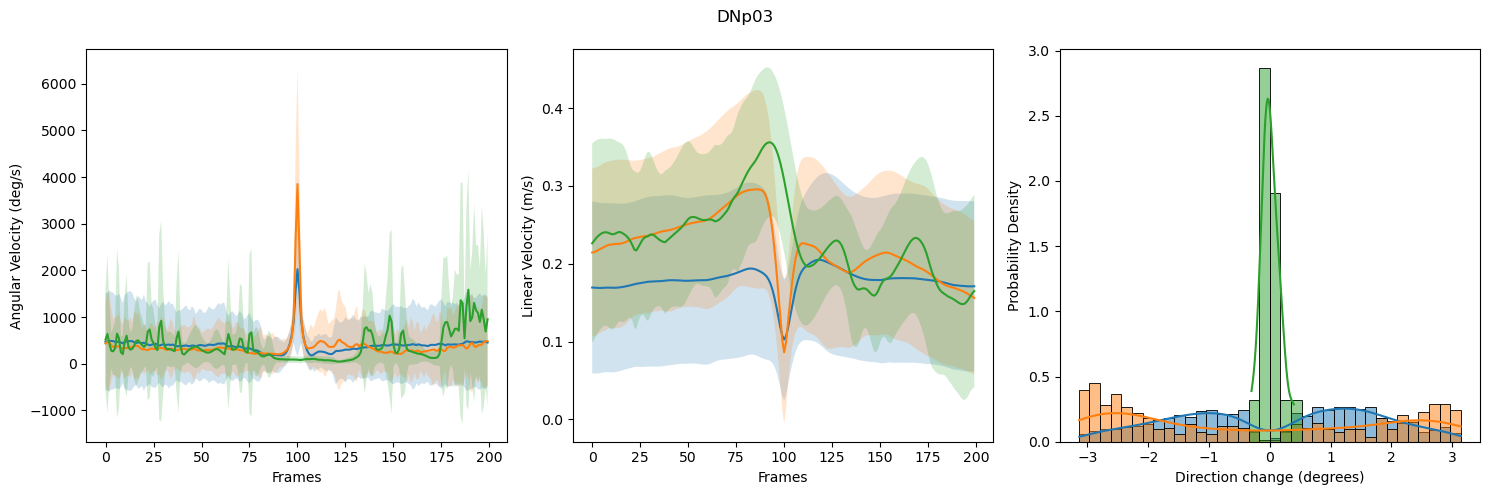

In [139]:
opto_summary_plot(j53_results, "DNp03")

#### AX-Split

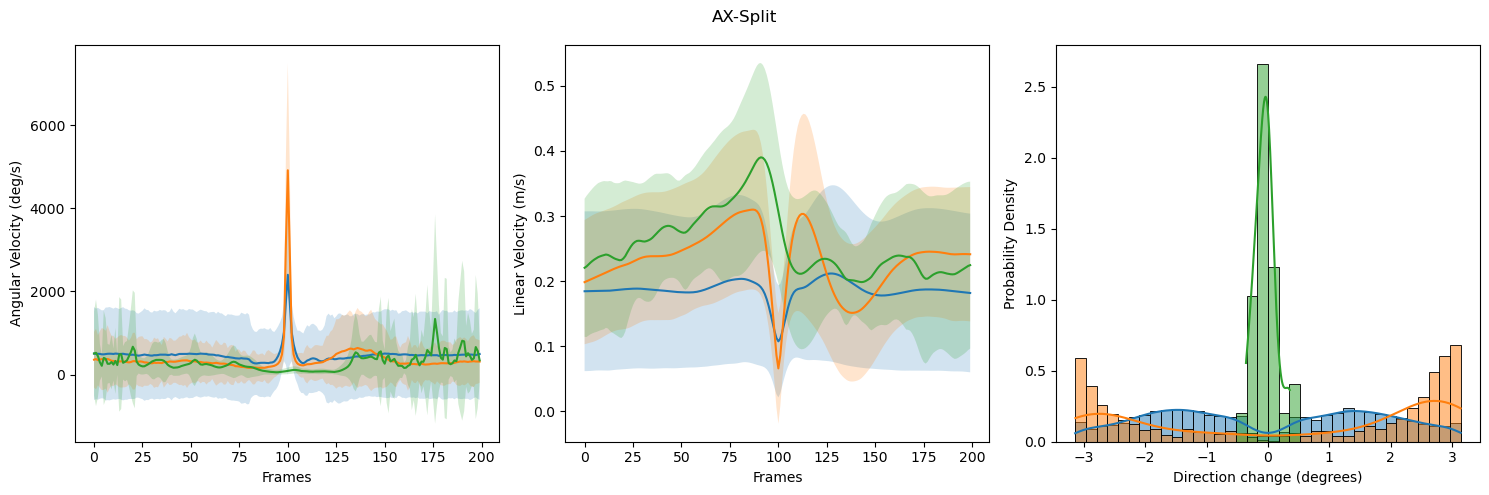

In [142]:
opto_summary_plot(g29_results, "AX-Split")

#### Empty-Split

### Combined angular velocity plot

In [82]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

# stimulus-elicited only
# angvel
plot_mean_and_std(
    empty_split_results["stim_angvels"],
    label="Empty-Split",
    ax=axs[0],
    take_abs=True,
    convert_to_degrees=True,
    peak_align=False,
)
plot_mean_and_std(
    g29_results["stim_angvels"],
    label="AX-Split",
    ax=axs[0],
    take_abs=True,
    convert_to_degrees=True,
    peak_align=False,
)
plot_mean_and_std(
    j53_results["stim_angvels"],
    label="DNp03",
    ax=axs[0],
    take_abs=True,
    convert_to_degrees=True,
    peak_align=False,
)

# linvel
plot_mean_and_std(
    empty_split_results["stim_linvels"],
    label="Empty-Split",
    ax=axs[1],
    peak_align=False,
)
plot_mean_and_std(
    g29_results["stim_linvels"], label="AX-Split", ax=axs[1], peak_align=False
)
plot_mean_and_std(
    j53_results["stim_linvels"], label="DNp03", ax=axs[1], peak_align=False
)

# heading_difference
plot_histogram(
    empty_split_results["stim_heading_diffs"], label="Empty-Split", ax=axs[2]
)
plot_histogram(g29_results["stim_heading_diffs"], label="AX-Split", ax=axs[2])
plot_histogram(j53_results["stim_heading_diffs"], label="DNp03", ax=axs[2])


axs[0].axvspan(0, 0.3, color="gray", alpha=0.2)
axs[1].axvspan(0, 0.3, color="gray", alpha=0.2)

axs[0].set_xlim(-0.5, 1.0)
axs[1].set_xlim(-0.5, 1.0)
axs[2].set_xlim(-np.pi, np.pi)

axs[0].set_xlabel("Time (s)")
axs[1].set_xlabel("Time (s)")
axs[2].set_xlabel("Direction change (rad)")

axs[0].set_ylabel("Angular Velocity (deg/s)")
axs[1].set_ylabel("Linear Velocity (m/s)")

plt.suptitle("Stimulus-Elicited Saccades")
plt.tight_layout()

plt.savefig(
    "/home/buchsbaum/src/fly_analysis/notebooks/Figures/dnp03_paper/combined_analysis.png",
    dpi=300,
)
plt.savefig(
    "/home/buchsbaum/src/fly_analysis/notebooks/Figures/dnp03_paper/combined_analysis.svg",
    dpi=300,
)
plt.savefig(
    "/home/buchsbaum/src/fly_analysis/notebooks/Figures/dnp03_paper/combined_analysis.pdf",
    dpi=300,
)
plt.close("all")


In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="polar")
# ax.hist(empty_split_results["stim_heading_diffs"])

plt.show()

## Looming

In [ ]:
# Process emptyxu68 files
print("Processing emptyxu68 files")
looming_files = [
    "20240702_140401.braidz",
    "20240712_153309.braidz",
    "20240715_171206.braidz",
    "20240930_120514.braidz",
]
looming_data = fa.braidz.read_multiple_braidz(looming_files, root_folder)

In [104]:
looming_results = get_all_saccade_data(looming_data["df"], looming_data["stim"], delay=30)

100%|██████████| 476/476 [00:35<00:00, 13.46it/s]


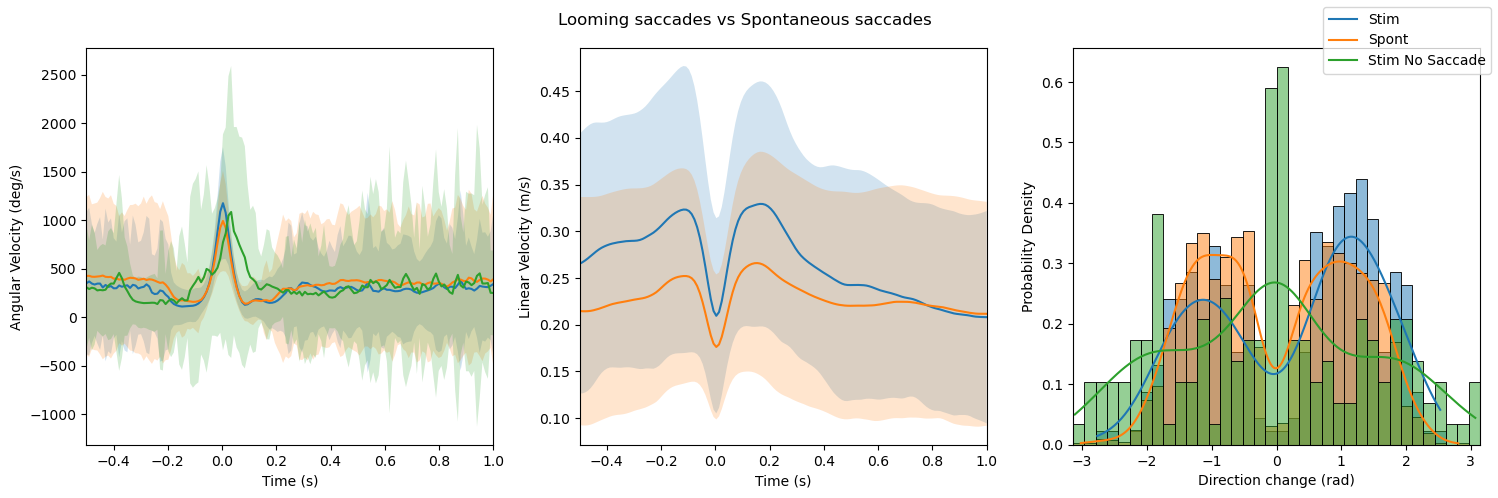

In [105]:
stim_w_saccade_idx = np.array([i for i, x in enumerate(looming_results["group"]) if x == "stim_w_saccade"]).astype(int)
stim_no_saccade_idx = np.array([i for i, x in enumerate(looming_results["group"]) if x == "stim_no_saccade"]).astype(int)
spont_saccade_idx = np.array([i for i, x in enumerate(looming_results["group"]) if x == "spont_saccade"]).astype(int)

angular_velocity = np.array(looming_results["angular_velocity"])
linear_velocity = np.array(looming_results["linear_velocity"])
heading_differences = np.array(looming_results["heading_diff"])

fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

# angvel
plot_mean_and_std(
    angular_velocity[stim_w_saccade_idx],
    label="Stim",
    ax=axs[0],
    take_abs=True,
    convert_to_degrees=True,
    units="ms",
)
plot_mean_and_std(
    angular_velocity[spont_saccade_idx],
    label="Spont",
    ax=axs[0],
    take_abs=True,
    convert_to_degrees=True,
    units="ms",
)
plot_mean_and_std(
    angular_velocity[stim_no_saccade_idx],
    label="Stim No Saccade",
    ax=axs[0],
    take_abs=True,
    convert_to_degrees=True,
    units="ms",
)

# linvel
plot_mean_and_std(linear_velocity[stim_w_saccade_idx], ax=axs[1], units="ms")
plot_mean_and_std(linear_velocity[spont_saccade_idx], ax=axs[1], units="ms")

# heading_difference
plot_histogram(heading_differences[stim_w_saccade_idx], ax=axs[2])
plot_histogram(heading_differences[spont_saccade_idx], ax=axs[2])
plot_histogram(heading_differences[stim_no_saccade_idx], ax=axs[2])
axs[2].set_xlim(-np.pi, np.pi)
for ax in axs[:2]:
    ax.set_xlim(-0.5, 1.0)
    ax.set_xlabel("Time (s)")

axs[1].set_ylabel("Linear Velocity (m/s)")
axs[2].set_xlabel("Direction change (rad)")
axs[2].set_ylabel("Probability Density")

plt.suptitle("Looming saccades vs Spontaneous saccades")
plt.tight_layout()
fig.legend()

plt.show()
# plt.savefig(
#     "/home/buchsbaum/src/fly_analysis/notebooks/Figures/dnp03_paper/looming_stim_vs_spont_saccades_only.png",
#     dpi=300,
# )
# plt.savefig(
#     "/home/buchsbaum/src/fly_analysis/notebooks/Figures/dnp03_paper/looming_stim_vs_spont_saccades_only.svg",
#     dpi=300,
# )
# plt.savefig(
#     "/home/buchsbaum/src/fly_analysis/notebooks/Figures/dnp03_paper/looming_stim_vs_spont_saccades_only.pdf",
#     dpi=300,
# )
# plt.close("all")
